# Import Dependencies

In [1137]:
# System
import os

# Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

import tensorflow as tf

import pickle

# Get Data

In [1138]:
file_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/cutfree-simulations/runtime_data_v2.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()
df.iloc[0]

Oligo                        NNNNNN
OligoLength                       6
Sites                   Any["YATR"]
TotalSites                        1
SiteLength                        4
CutFree_Randomer             NBNVVN
CutFree_Degeneracy          7.45472
CutFree_Time               0.006211
CutFreeRL_Randomer           NNVVVN
CutFreeRL_Degeneracy        7.45472
CutFreeRL_Time             0.228063
Name: 0, dtype: object

In [1139]:
df.loc[(df["OligoLength"] == 6) & (df["TotalSites"] == 1) & (df["SiteLength"] == 4)]

,Oligo,OligoLength,Sites,TotalSites,SiteLength,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time
0,NNNNNN,6,"Any[""YATR""]",1,4,NBNVVN,7.454720,0.006211,NNVVVN,7.454720,0.228063
1750,NNNNNN,6,"Any[""GATC""]",1,4,HNNNDD,7.454720,0.006383,NNNDDD,7.454720,0.225150
3500,NNNNNN,6,"Any[""GGCC""]",1,4,NHNNDN,7.742402,0.007255,NNNDND,7.742402,0.080954


# Data Classification

In [1140]:
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]

values = [0, 1] # 0 = CutFree, 1 = CutFreeRL

df["Algorithm"] = np.select(conditions, values)
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm", "CutFree_Time", "CutFreeRL_Time"]]
df

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
1,6,2,4,0,0.007820,0.087950
2,6,3,4,0,0.010071,0.136403
3,6,4,4,0,0.013531,0.150443
4,6,5,4,0,0.013882,0.183784
...,...,...,...,...,...,...
5244,40,6,8,1,12.737720,4.200124
5245,40,7,8,1,60.120769,3.009765
5246,40,8,8,1,60.379011,3.989743
5247,40,9,8,1,60.156297,3.611050


# Rejection Sampling

In [1141]:
numCutFree = df[df.Algorithm == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Algorithm == 1].shape[0]
print(numCutFreeRL)

3731
1518


In [1142]:
df_rejection = df[df.Algorithm == 0].sample(numCutFree-numCutFreeRL)
df = df.drop(df_rejection.index)
df

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
4,6,5,4,0,0.013882,0.183784
5,6,6,4,0,0.011498,0.194223
11,6,2,5,0,0.006018,0.099851
19,6,10,5,0,0.030398,0.299281
...,...,...,...,...,...,...
5244,40,6,8,1,12.737720,4.200124
5245,40,7,8,1,60.120769,3.009765
5246,40,8,8,1,60.379011,3.989743
5247,40,9,8,1,60.156297,3.611050


In [1143]:
numCutFree = df[df.Algorithm == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Algorithm == 1].shape[0]
print(numCutFreeRL)

1518
1518


In [1144]:
df_total = df.copy()
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm"]]

# Visualize Data

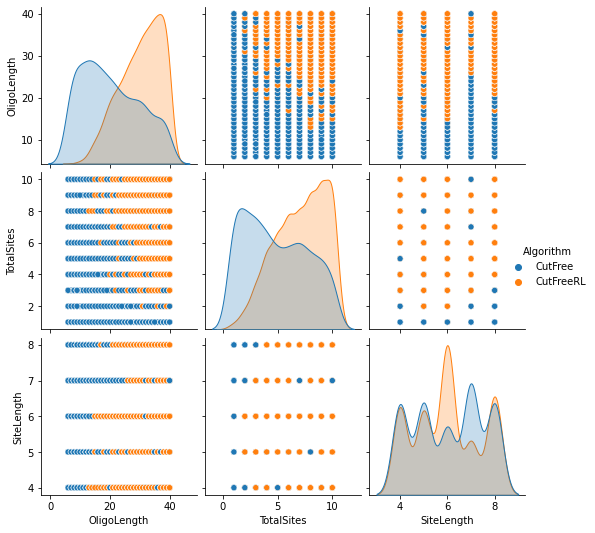

In [1145]:
pair_plot = sns.pairplot(df, hue="Algorithm", diag_kind="kde")
new_labels = ["CutFree", "CutFreeRL"]
for t, l in zip(pair_plot._legend.texts, new_labels):
    t.set_text(l)
plt.show(pair_plot)

# Get Train/Test Split

In [1146]:
x = df.drop(["Algorithm"], axis=1)
y = df["Algorithm"]

In [1147]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=0.2, random_state=1)
x_train_df.head()

,OligoLength,TotalSites,SiteLength
4277,21,8,6
2640,23,1,8
540,16,1,8
4182,19,3,7
3382,38,3,7


In [1148]:
y_train_df.head()

4277    1
2640    0
540     0
4182    0
3382    1
Name: Algorithm, dtype: int32

In [1149]:
x_train, y_train = tf.convert_to_tensor(x_train_df, dtype=tf.float32), tf.convert_to_tensor(y_train_df, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test_df, dtype=tf.float32), tf.convert_to_tensor(y_test_df, dtype=tf.float32)

In [1150]:
x_train

<tf.Tensor: shape=(2428, 3), dtype=float32, numpy=
array([[21.,  8.,  6.],
       [23.,  1.,  8.],
       [16.,  1.,  8.],
       ...,
       [11.,  4.,  8.],
       [17.,  2.,  6.],
       [ 9.,  6.,  7.]], dtype=float32)>

# Machine Learning

### Accuracy Function

In [1151]:
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true)*100
    print("Accuracy: {:.2f}%".format(test_accuracy))
    return test_accuracy

### TensorFlow NN

In [1152]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="tanh", input_shape=(3,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation="tanh"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="tanh"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="tanh"),
    tf.keras.layers.Dense(8, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 32)                128       
                                                                 
 batch_normalization_93 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_111 (Dropout)       (None, 32)                0         
                                                                 
 dense_193 (Dense)           (None, 32)                1056      
                                                                 
 dropout_112 (Dropout)       (None, 32)                0         
                                                                 
 dense_194 (Dense)           (None, 16)                528       
                                                     

In [1153]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    optimizer, 
    loss="mse", 
    metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
76/76 [==============================] - 1s 3ms/step - loss: 0.3237 - accuracy: 0.2965 - val_loss: 0.3075 - val_accuracy: 0.3454
Epoch 2/100
76/76 [==============================] - 0s 2ms/step - loss: 0.3171 - accuracy: 0.3072 - val_loss: 0.3068 - val_accuracy: 0.2730
Epoch 3/100
76/76 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.3328 - val_loss: 0.3023 - val_accuracy: 0.2730
Epoch 4/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2985 - accuracy: 0.3567 - val_loss: 0.2965 - val_accuracy: 0.3043
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2924 - accuracy: 0.3748 - val_loss: 0.2897 - val_accuracy: 0.3372
Epoch 6/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2843 - accuracy: 0.4189 - val_loss: 0.2819 - val_accuracy: 0.3701
Epoch 7/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2744 - accuracy: 0.4502 - val_loss: 0.2736 - val_accuracy: 0.4424
Epoch 8/100
7

In [1154]:
y_pred_tf = np.round(model.predict(x_test)).reshape(1, -1)[0]
tf_acc = get_accuracy(y_pred_tf, y_test)

19/19 [==============================] - 0s 752us/step
Accuracy: 82.57%


### Plot Loss and Accuracy Curves

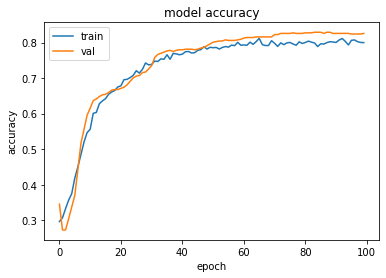

In [1155]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

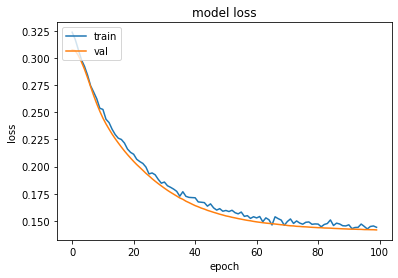

In [1156]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MLP Classifier NN

In [1157]:
class_NN = MLPClassifier(
    hidden_layer_sizes=(32, 32, 32, 32, 32),
    activation='tanh',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=1000, 
    verbose=0,
    random_state=1)
class_NN.fit(x_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(32, 32, 32, 32, 32),
              learning_rate='adaptive', max_iter=1000, random_state=1,
              verbose=0)

In [1158]:
y_pred = class_NN.predict(x_test)
mlp_acc = get_accuracy(y_pred, y_test)

Accuracy: 81.91%


In [1159]:
x_test[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([6., 5., 6.], dtype=float32)>

### Grid Search to Find Optimal Parameters

In [1160]:
params = {
    'hidden_layer_sizes' : [(64, 32, 32, 32, 16), (32, 32, 32, 32, 32)],
}

gscv = GridSearchCV(class_NN, params, verbose=1)

# gscv.fit(np.array(x_train), np.array(y_train))
# print(gscv.best_params_) 

### Analyze Results

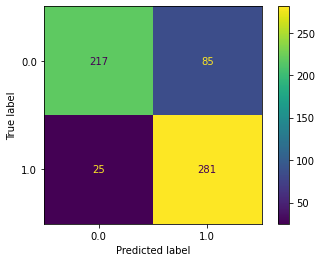

In [1161]:
plot_confusion_matrix(class_NN, x_test, y_test)  
plt.show()

In [1162]:
print(classification_report(y_pred, y_test, target_names=["CutFree", "CutFreeRL"]))

              precision    recall  f1-score   support

     CutFree       0.72      0.90      0.80       242
   CutFreeRL       0.92      0.77      0.84       366

    accuracy                           0.82       608
   macro avg       0.82      0.83      0.82       608
weighted avg       0.84      0.82      0.82       608



# Visualize Incorrect Classifications

In [1163]:
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
4,6,5,4,0,0.013882,0.183784
5,6,6,4,0,0.011498,0.194223
11,6,2,5,0,0.006018,0.099851
19,6,10,5,0,0.030398,0.299281


In [1164]:
df_total["Discrepency"] = df_total.CutFree_Time - df_total.CutFreeRL_Time
df_total = df_total.sort_values(by=["Discrepency"], ascending=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency
3139,33,10,7,0,0.632100,3.728101,-3.096001
4988,35,10,7,0,0.531718,3.553635,-3.021917
5238,40,10,7,0,0.919619,3.840002,-2.920383
1239,30,10,7,0,0.290017,3.013270,-2.723253
4945,34,7,8,0,0.143880,2.799703,-2.655823


In [1165]:
df_total_tf = df_total.copy()

df_total_tf.loc[x_test_df.index[np.where(y_test_df != y_pred_tf)], "Prediction"] = 0
df_total_tf.loc[df_total_tf["Prediction"].isna(), "Prediction"] = 1

df_total_tf = df_total_tf.reset_index(drop=True)


In [1166]:
df_total.loc[x_test_df.index[np.where(y_test_df != y_pred)], "Prediction"] = 0
df_total.loc[df_total["Prediction"].isna(), "Prediction"] = 1


In [1167]:
df_total = df_total.reset_index(drop=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency,Prediction
0,33,10,7,0,0.632100,3.728101,-3.096001,1.0
1,35,10,7,0,0.531718,3.553635,-3.021917,1.0
2,40,10,7,0,0.919619,3.840002,-2.920383,1.0
3,30,10,7,0,0.290017,3.013270,-2.723253,1.0
4,34,7,8,0,0.143880,2.799703,-2.655823,1.0


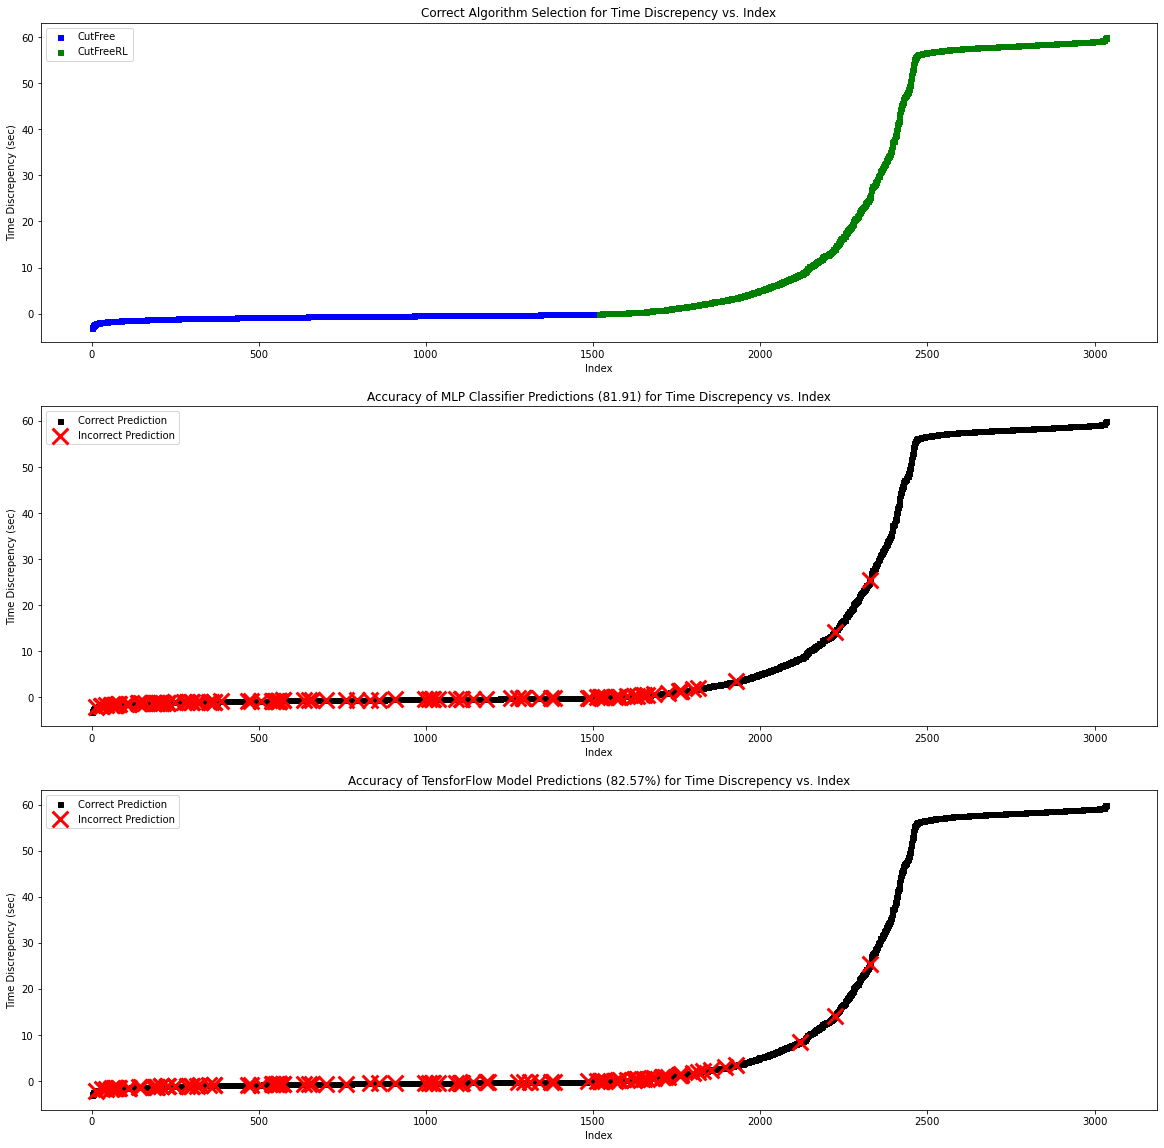

In [1168]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.scatter(
    df_total[df_total.Algorithm==0].index, df_total[df_total.Algorithm==0].Discrepency, 
    c ="blue",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Algorithm==1].index, df_total[df_total.Algorithm==1].Discrepency, 
    c ="green",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.title("Correct Algorithm Selection for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["CutFree", "CutFreeRL"])

plt.subplot(312)
plt.scatter(
    df_total[df_total.Prediction==1].index, df_total[df_total.Prediction==1].Discrepency, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Prediction==0].index, df_total[df_total.Prediction==0].Discrepency, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title(f"Accuracy of MLP Classifier Predictions ({mlp_acc:.2f}) for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["Correct Prediction", "Incorrect Prediction"])

plt.subplot(313)
plt.scatter(
    df_total_tf[df_total_tf.Prediction==1].index, df_total_tf[df_total_tf.Prediction==1].Discrepency, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total_tf[df_total_tf.Prediction==0].index, df_total_tf[df_total_tf.Prediction==0].Discrepency, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title(f"Accuracy of TensforFlow Model Predictions ({tf_acc:.2f}%) for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["Correct Prediction", "Incorrect Prediction"])


# Save Model

In [1169]:
with open("cutfree_model.pkl", "wb") as f:
    pickle.dump(class_NN, f)

In [1170]:
with open("../cutfree-models/cutfree_model.pkl", "rb") as f:
    model = pickle.load(f)
model.predict([[6, 1, 4]])

array([0.], dtype=float32)